In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets,transforms,models
from torch import optim
from PIL import Image
import numpy as np
import seaborn as sns

In [11]:
data_dir = 'goods'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
print((train_dir))

goods/train


In [12]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                        [0.229,0.224,0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                        [0.229,0.224,0.225])])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                        [0.229,0.224,0.225])])

train_dataset =datasets.ImageFolder(train_dir,transform =train_transforms)
val_dataset = datasets.ImageFolder(valid_dir,transform =val_transforms)
test_dataset = datasets.ImageFolder(test_dir,transform =test_transforms)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

print(len(test_dataset))
print(len(train_dataset))
print(len(val_dataset))

73
107
74


In [15]:
import json

with open('goods_file.json', 'r') as f:
    cat_to_name = json.load(f)
    print(cat_to_name)

{'01': 'apple', '02': 'cherry tomato', '03': 'grape', '04': 'green chilli', '05': 'jack fruit', '06': 'egg plant', '07': 'mixed fruit', '08': 'pumpkim', '09': 'corn', '10': 'cut water melon', '11': 'dragon fruit', '12': 'baby corn', '13': 'cauliflower', '14': 'water melon', '15': 'chinese cabbage', '16': 'bitter groud', '17': 'baby tamarind', '18': 'cut papaya', '19': 'chicken drumette', '20': 'chicken wings', '21': 'fish', '22': 'cabbage', '23': 'strawberry'}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
        ('fc1',nn.Linear(25088,2500)),
        ('relu1',nn.ReLU()),
        ('drop',nn.Dropout(0.3)),
    
        ('fc2',nn.Linear(2500,1000)),
        ('relu2',nn.ReLU()),
        ('drop',nn.Dropout(0.3)),
    
        ('fc4',nn.Linear(1000,102)),
        ('output',nn.LogSoftmax(dim=1))]))

model.classifier = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to(device)

epochs = 15
steps = 0
train_losses, valid_losses = [], []
running_loss = 0
print_every = 2
for epoch in range(epochs):
    for inputs,labels in trainloader:
        steps += 1
        inputs,labels = inputs.to(device),labels.to(device)
            
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps,labels)
        #print(loss)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs,labels in validloader:
                    inputs,labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps,labels)
                    valid_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p,top_class = ps.topk(1,dim =1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            valid_losses.append(valid_loss/len(validloader))
            print(f"Epoch{epoch+1}/{epochs}.."
                  f"Train loss: {running_loss/print_every:.3f}.."
                  f"valid lossS: {valid_loss/len(validloader):.3f}.."
                  f"valid accuracy : {accuracy/len(validloader):.3f}..")
            running_loss = 0
            model.train()

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)    

In [ ]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs,labels in testloader:
        inputs,labels = inputs.to(device),labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps,labels)
        test_loss += batch_loss.item()
                    
        ps = torch.exp(logps)
        top_p,top_class = ps.topk(1,dim =1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        print(f"Test lossS: {test_loss/len(testloader):.3f}.."
                f"Test accuracy: {accuracy/len(testloader):.3f}..")

In [ ]:
model.class_to_idx = train_dataset.class_to_idx 
torch.save({'state_dict': model.state_dict(),
            'drop_out':0.3,
            'epoch':15,
            'classifier': model.classifier,
           'class_to_idx': model.class_to_idx,
           'optimizer_dict': optimizer.state_dict()},'checkpoint.pth')

In [ ]:
device = torch.device("cpu")
model = models.vgg16(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
model.to(device)

In [21]:
#def load_checkpoint(filepath):
checkpoint = torch.load('checkpoint.pth',map_location='cpu')
model.classifier = checkpoint['classifier']
model.class_to_idx = checkpoint['class_to_idx']
model.load_state_dict(checkpoint['state_dict'])
model.eval()
#return model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

RGBA


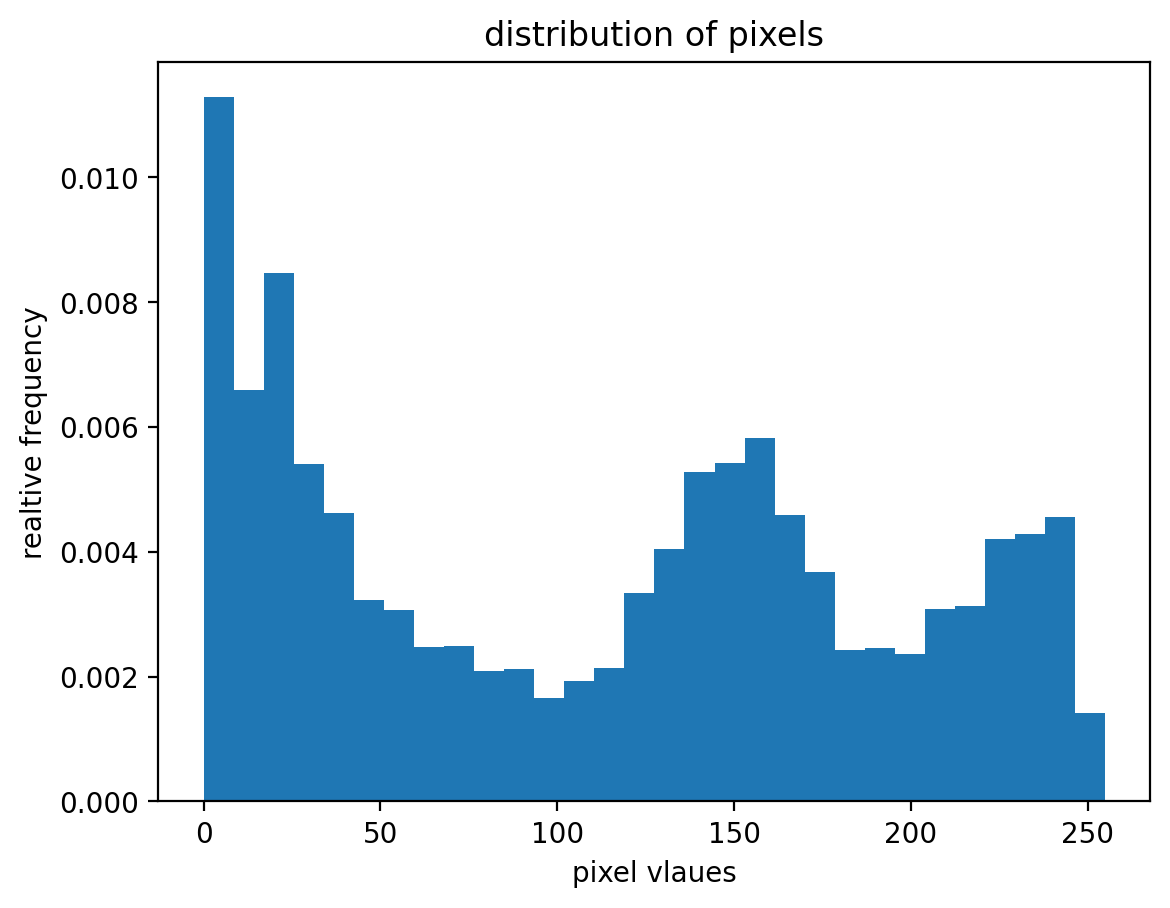

In [9]:
img_path = 'goods/test/02/image_07.png'
img = Image.open(img_path)
print(img.mode)
if img.mode =='RGBA':
    rgb_image = img.convert('RGB')
    img_np = np.array(rgb_image)
    plt.hist(img_np.ravel(), bins = 30 , density = True)
    plt.xlabel('pixel vlaues')
    plt.ylabel('realtive frequency')
    plt.title('distribution of pixels')
    #print(img_np)
    img_np.shape

In [11]:
def process_image(image):
    with Image.open(image) as im:
        width = im.width
        height = im.height
        if width < height:
            width,height = 230,250
        else:
            width,height =250,230
        img = im.resize((width,height))
        
        center = width/2,height/2
        print((center))
        left,right,top,bottom =center[0]-(244/2),center[1]-(244/2),center[0]+(244/2),center[1]+(244/2)
        
        img = img.crop((left,right,top,bottom))
        rgb_image = img.convert('RGB')
        np_img = np.array(rgb_image)/255
        
        mean = [0.485,0.456,0.406]
        std = [0.229,0.224,0.225]
        np_img = (np_img-mean)/std
        np_img = np_img.transpose(2,0,1)
        
        return np_img


(125.0, 115.0)


<AxesSubplot: >

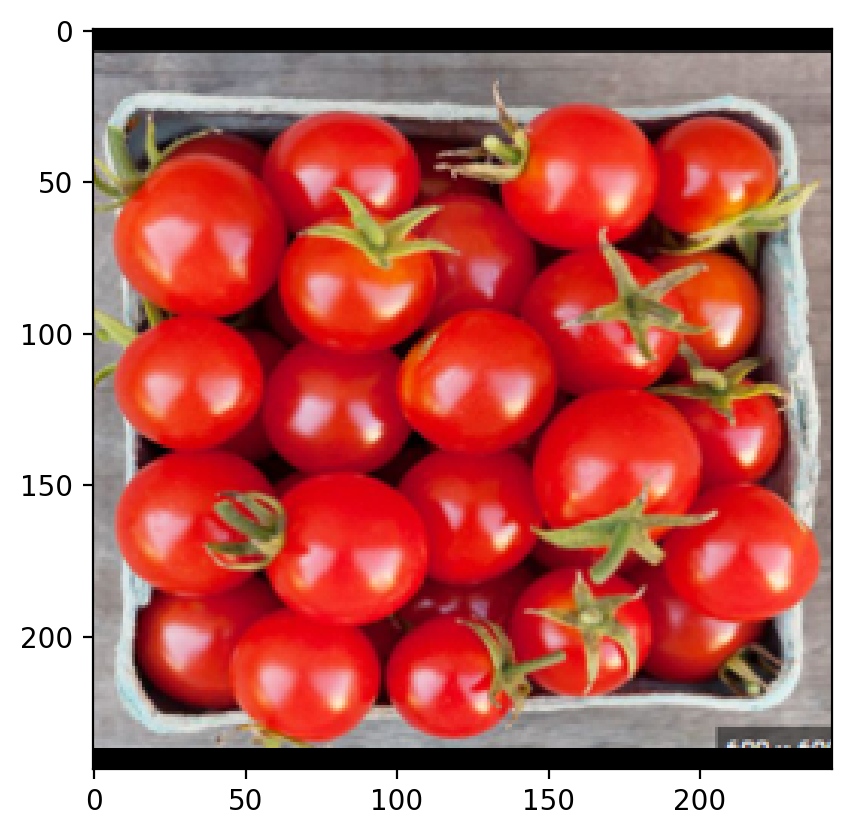

In [12]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
imshow(process_image("goods/test/02/image_07.png"))

In [17]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval();
    model.to("cpu")
    tor_img = torch.from_numpy(np.expand_dims(process_image(image_path),axis = 0)).type(torch.FloatTensor).to("cpu")
    logps = model.forward(tor_img)
    linps = torch.exp(logps)
    
    top_probs,top_labels = linps.topk(topk)
    top_probs = np.array(top_probs.detach())[0]
    top_labels = np.array(top_labels.detach())[0]
    
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    return top_probs,top_labels,top_flowers
    # TODO: Implement the code to predict the class from an image file

(125.0, 115.0)
(125.0, 115.0)


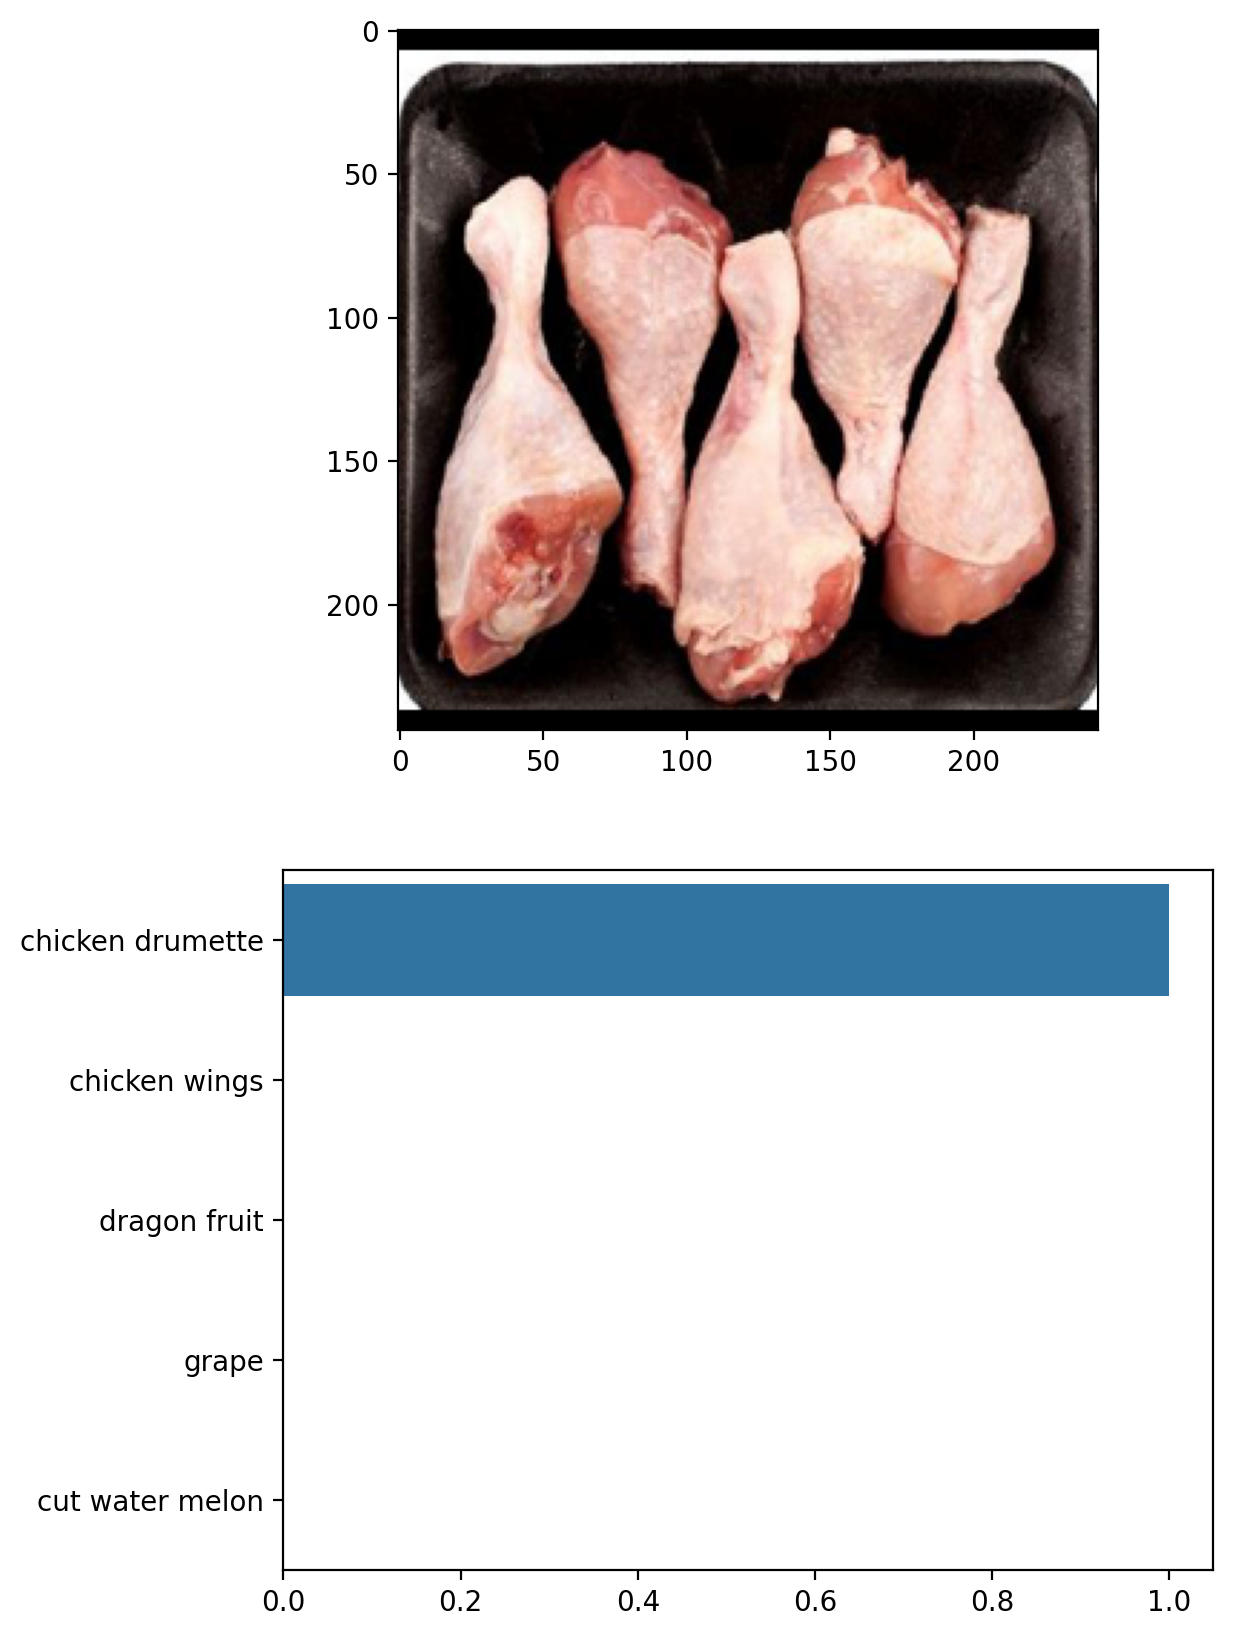

In [22]:
import seaborn as sns
image_path ='goods/train/19/image_91.jpg'
plt.figure(figsize=(6,10))
ax = plt.subplot(2,1,1)
flower_num = image_path.split('/')[2]
flower_title = cat_to_name[flower_num]
img = process_image(image_path)
imshow(img,ax,title=flower_title);

probs,labs,goods = predict(image_path,model)
plt.subplot(2,1,2)
sns.barplot(x=probs,y=goods,color=sns.color_palette()[0]);
plt.show()